# Read the Data

## About the Data

The dataset I'm using is from [Kaggle](https://www.kaggle.com/dcohen21/8anu-climbing-logbook). It was collected from the website [8a.nu](https://www.8a.nu/) by David Cohen. This dataset was collected on 9/13/2017.

The idea behind [8a.nu](https://www.8a.nu/) is to provide a logbook for climbers to keep track of their climbs digitally. Many climbers have a manual logbook that they use to keep track of this information, and [8a.nu](https://www.8a.nu/) provides a digital alternative to this. Fortunately for us this means we have a wealth of information available.

## Import the Data

The download from [Kaggle](https://www.kaggle.com/dcohen21/8anu-climbing-logbook) is in sqlite format, which is nice, but pandas seemed to read this information quite slowly so I converted each of the tables within the database into csv's from the sqlite3 interface. Pandas reads the csv files much faster.

In [1]:
import pandas as pd
import numpy as np
from pandas.api.types import CategoricalDtype

from datetime import datetime
import re

import matplotlib.pyplot as plt
import seaborn as sns


sns.set()

%matplotlib inline

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100

In [2]:
# read the previously cleaned data
input_path = '../data/cleaned/'
climbs_all = pd.read_csv(input_path + 'climbing_data.csv', 
                         low_memory=False, 
                         parse_dates=['date', 'birth']).drop(columns='Unnamed: 0')
climbers = pd.read_csv(input_path + 'users_cleaned.csv').drop(columns='Unnamed: 0')
grades = pd.read_csv(input_path + 'grades_cleaned.csv').drop(columns='Unnamed: 0')

input_pop_path = '../data/input/'
pop = pd.read_csv(input_pop_path + "population/POP_TOTAL_DS2_en_v5.csv")
pop2015 = pop.loc[:,['Country Name', 'Country Code', 'Indicator Code', '2015']]


# convert the USA rating columns back to the categorical data created in the cleaning notebook
usa_routes_type = CategoricalDtype(categories = list(grades.usa_routes.unique()),
                                   ordered = True)
usa_boulders_type = CategoricalDtype(categories = list(grades.usa_boulders.unique()),
                                   ordered = True)

climbs_all['usa_routes'] = climbs_all.usa_routes.astype(usa_routes_type)
climbs_all['usa_boulders'] = climbs_all.usa_boulders.astype(usa_boulders_type)

# convert population to per 1000 as it's simply easier to look at
pop2015.assign(_2015 = pop2015['2015']).drop(columns='2015')
pop2015['per_thousand'] = pop2015['2015'] / 1000.0


# later analysis on max grade vs bmi highlighted a distinct problem with data input for climbers that had entered invalid weights
f = (climbs_all.user_id.isin(climbers[(climbers.bmi > 28)].id) &
     (climbs_all.usa_routes >= '5.12a'))
climbs_all = climbs_all[~f]

climbs_all = climbs_all[~climbs_all.user_id.isin([38076, 21459, 5566, 21285, 47459, 61779])]

## Begin Exploration

## Questions
1. Sex
    * proportion of female users in database
    * proportion of new female climbers - is it increasing?
    * proportion of female climbers by year
2. Weight
    * can we observe any relationships between BMI and grades
3. Height
    * can we observe any relationships between height and grades
4. Age
    * can we observe any relationships between height and grades
    * does max grade decline over time
    
Setup some a palette and some common plotting parameters.

In [3]:
mrd_palette = (['#1f77b4'] +
               sns.xkcd_palette(['rose pink']) +
               ['#bac6cc', # grey / blue
                '#549163', # green
                '#2eab4b', # brighter green
                '#ed933e', # orange
               ])

TITLE_SIZE = 24
LABEL_SIZE = 16
TICK_SIZE = 16
ANNOTATION_SIZE = 20

OUTPUT_PATH = '../imgs/'

FIG_SIZE = (10,6)

Build some dataframes to use for analysis.

In [4]:
climbers_big = pd.merge(left = climbs_all, left_on = 'country_climber',
             right = pop2015.drop(columns = 'Indicator Code'), right_on = 'Country Code',
             how = 'left'
            ).rename(columns={'Country Name':'country_climber_name',
                              'Country Code':'country_climber_code'}).drop(columns=['2015', 'per_thousand'])
climbers_big = pd.merge(left = climbers_big, left_on = 'country_route',
             right = pop2015.drop(columns = 'Indicator Code'), right_on = 'Country Code',
             how = 'left'
            ).rename(columns={'Country Name':'country_route_name',
                              'Country Code':'country_route_code'})

climbers_sex = climbers_big.groupby(['sex','user_id'])[['grade_id', 
                                                        'height', 
                                                        'weight', 
                                                        'bmi', 
                                                        'started', 
                                                        'country_climber', 
                                                        'country_climber_name']].first().reset_index()

### Look at Weight and BMI vs Height

This is just something I've been curious at exploring and this seems like an opportune time to do so.

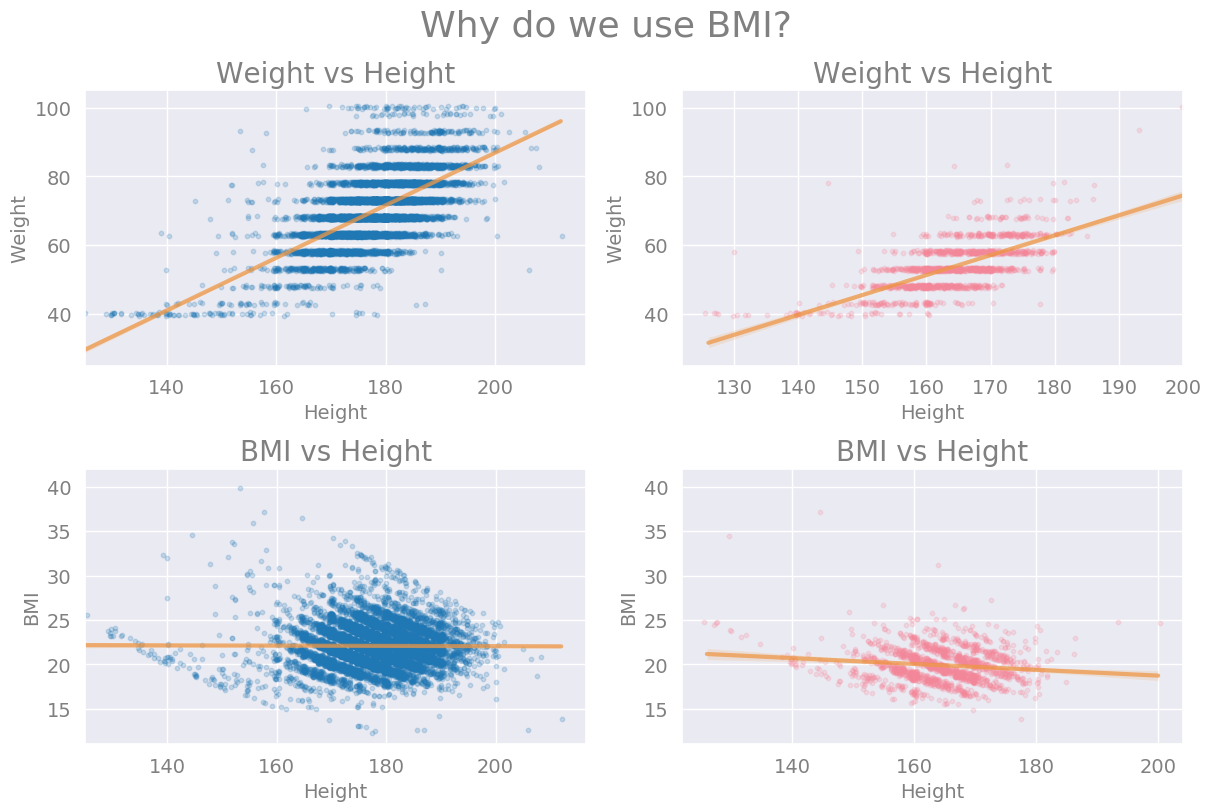

In [5]:
def plot_weight_bmi(y, sex, ax, x = "height"):
    x_jit = 0.5
    y_jit = 0.5
    alpha_m = 0.7
    alpha_f = 0.7
    alpha = alpha_m
    line_weight = 3
    line_kws={"color":mrd_palette[5], 'alpha':alpha, 'lw':line_weight}
    scatter_kws={"alpha":0.2, 's':10}

    if sex == "Male":
        color = mrd_palette[0]
    else:
        color = mrd_palette[1]
           
    sns.regplot(x=x, 
                y=y, 
                data=climbers_sex[climbers_sex.sex == sex],
                fit_reg = True,
                x_jitter=x_jit,
                y_jitter=y_jit,
                ax = ax,
                color = color,
                scatter_kws=scatter_kws,
                line_kws=line_kws)
    
    y_text = y.upper() if y == 'bmi' else y.title()
    ax.set_title(y_text + ' vs ' + x.title(), size = TITLE_SIZE - 4, color = 'grey')
    ax.set_xlabel(x.title(), size = LABEL_SIZE - 2, color = 'grey')
    ax.set_ylabel(y_text, size = LABEL_SIZE - 2, color = 'grey')
    ax.tick_params(axis='both', labelcolor = 'grey', labelsize=TICK_SIZE-2)

with sns.axes_style("darkgrid"):
    fig, ((p1, p2), (p3, p4)) = plt.subplots(nrows=2, ncols=2, figsize=(12,8), constrained_layout=True)
    plot_weight_bmi(y='weight', sex='Female', ax = p2)
    plot_weight_bmi(y='bmi', sex='Female', ax = p4)
    plot_weight_bmi(y='weight', sex='Male', ax = p1)
    plot_weight_bmi(y='bmi', sex='Male', ax = p3)

    for p in [p1, p2]:
        p.set_ylim(25, 105)
    for p in [p3, p4]:
        p.set_ylim(11, 42)

plt.suptitle("Why do we use BMI?", fontsize = TITLE_SIZE + 2, color = 'grey')
plt.savefig(OUTPUT_PATH + 'bmi.png')
plt.show()

### Distribution of Sex

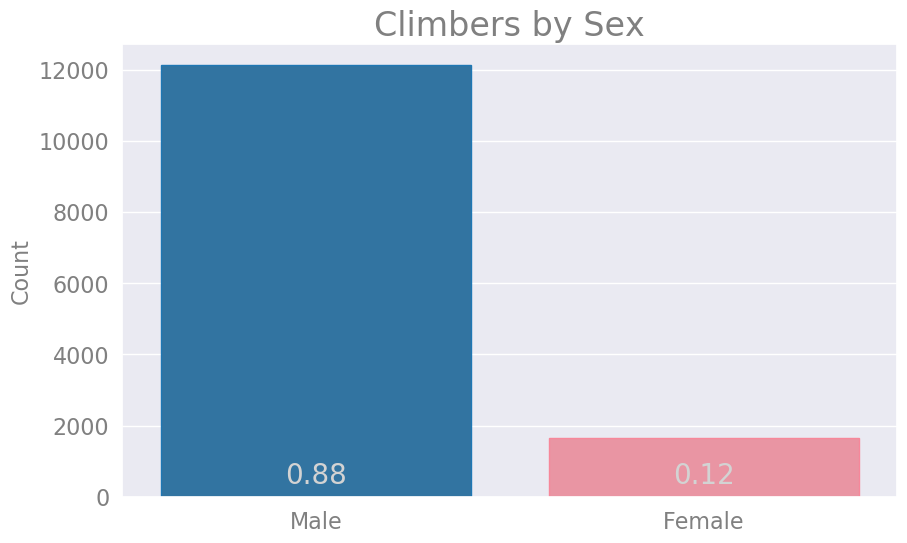

In [6]:
with sns.axes_style('darkgrid'):
    fig, p = plt.subplots(figsize=FIG_SIZE)
    bars = sns.countplot(data=climbers_sex,
                  x="sex",
                  palette = mrd_palette,
                  edgecolor = mrd_palette,
                  order=['Male', 'Female'])

    p.tick_params(axis='both', labelcolor = 'grey', labelsize=TICK_SIZE)

    plt.title('Climbers by Sex', fontsize = TITLE_SIZE, color = 'grey')
    plt.ylabel('Count', fontsize = LABEL_SIZE, color = 'grey')
    bars.tick_params(axis='both', labelcolor = 'grey', labelsize=16)
    plt.xlabel('')

    sex_counts = climbers_sex.groupby('sex').count()
    select_sex = ['Male', 'Female']
    for i, rect in enumerate(bars.patches):
        x=rect.get_bbox().get_points()[:,0]
        label = str(round(sex_counts.loc[select_sex[i], 'user_id'] / sex_counts.user_id.sum(),2))
        bars.annotate(label, (x.mean(), 200), ha='center', va='bottom', color = 'lightgrey', fontsize = ANNOTATION_SIZE)

plt.savefig(OUTPUT_PATH + "by_sex.png")
plt.show()

### Proportion of New Climbers That Are Female

In [7]:
# over and over again we will be adding proportional errors to dataframes
# to insure the calculation is performed correctly so let's write a function
def df_add_prop_error(df_original, pre):
    df = df_original.copy()
    prop = pre + '_prop'
    count = pre + '_count'
    total = pre + '_total'
    df[prop] = df[count] / df[total]
    df[prop + '_sd'] = np.sqrt(df[prop]*(1-df[prop])/df[total])
    df[prop + '_err'] = 1.96*df[prop + '_sd']
    df[prop + '_ci_low'] = df[prop] - df[prop + '_err']
    df[prop + '_ci_high'] = df[prop] + df[prop + '_err']
    
    return df.reset_index()

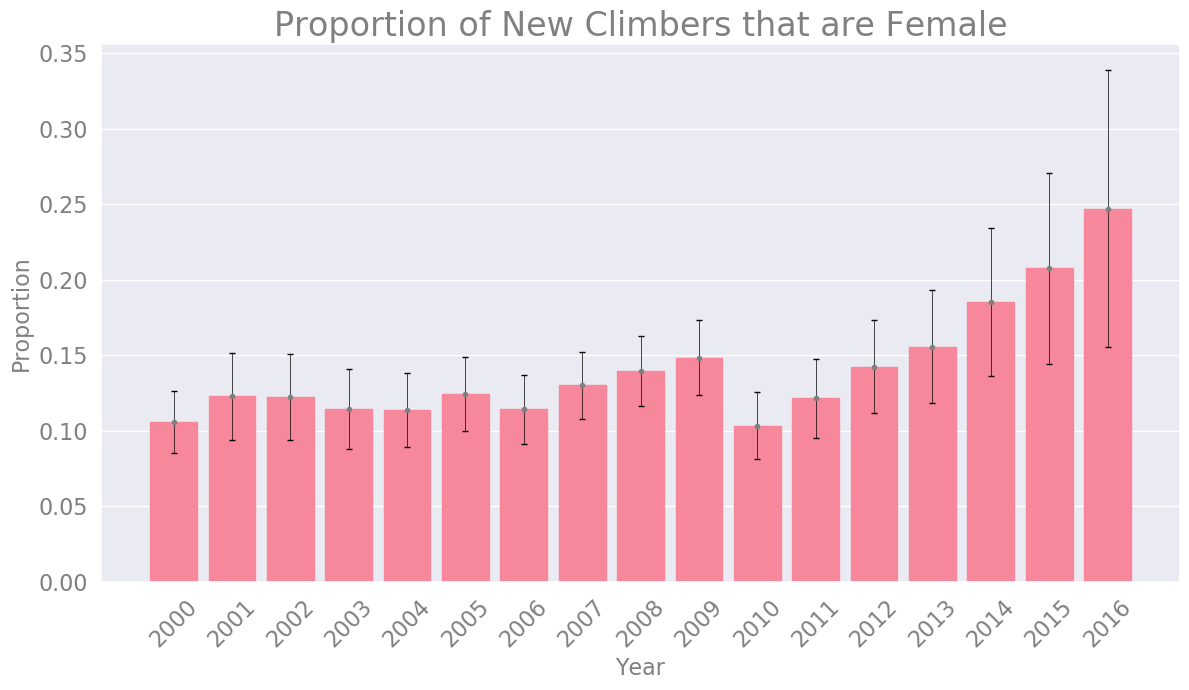

In [8]:
y_start = 2000
y_end = 2016
f = (climbers_sex.started >= y_start) & (climbers_sex.started <= y_end)
final_fem_new = (climbers_sex[f]
                 .groupby(['started', 'sex'])[['sex']]
                 .count()
                 .rename(columns={'sex':'sex_count'})
                )

# add some calculations to make sure proportional error bars are plotted correctly
totals_fem_new = (final_fem_new
                  .reset_index()
                  .groupby('started')
                  .sex_count
                  .sum())
final_fem_new = final_fem_new.reset_index().set_index('started')
final_fem_new['sex_total'] = totals_fem_new
final_fem_new = df_add_prop_error(final_fem_new, 'sex')
fem = final_fem_new[final_fem_new.sex == 'Female']

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(12,7))
    ax.bar(fem.started, 
           fem.sex_prop, 
           color = sns.xkcd_palette(['rose pink'])[0], 
           edgecolor = sns.xkcd_palette(['rose pink'])[0])

    ax.errorbar(x=fem.started, 
                 y = fem.sex_prop, 
                 yerr = fem.sex_prop_err,
                 fmt='.', color='grey',
                 ecolor='black', elinewidth=0.5, capsize=2
                )

    ax.set_xticks(fem.started)
    ax.set_xticklabels(fem.started, rotation=45, fontsize = TICK_SIZE, color = 'grey')
    ax.tick_params(axis='y', labelcolor = 'grey', labelsize=TICK_SIZE)
    ax.xaxis.grid(linewidth=0)
    ax.set_title('Proportion of New Climbers that are Female', fontsize = TITLE_SIZE, color = 'grey')
    ax.set_ylabel('Proportion', fontsize = LABEL_SIZE, color = 'grey')
    ax.set_xlabel('Year', fontsize = LABEL_SIZE, color = 'grey')

plt.tight_layout()
plt.savefig(OUTPUT_PATH + "female_new.png")
plt.show()

### Distribution of Female Climbers By Country

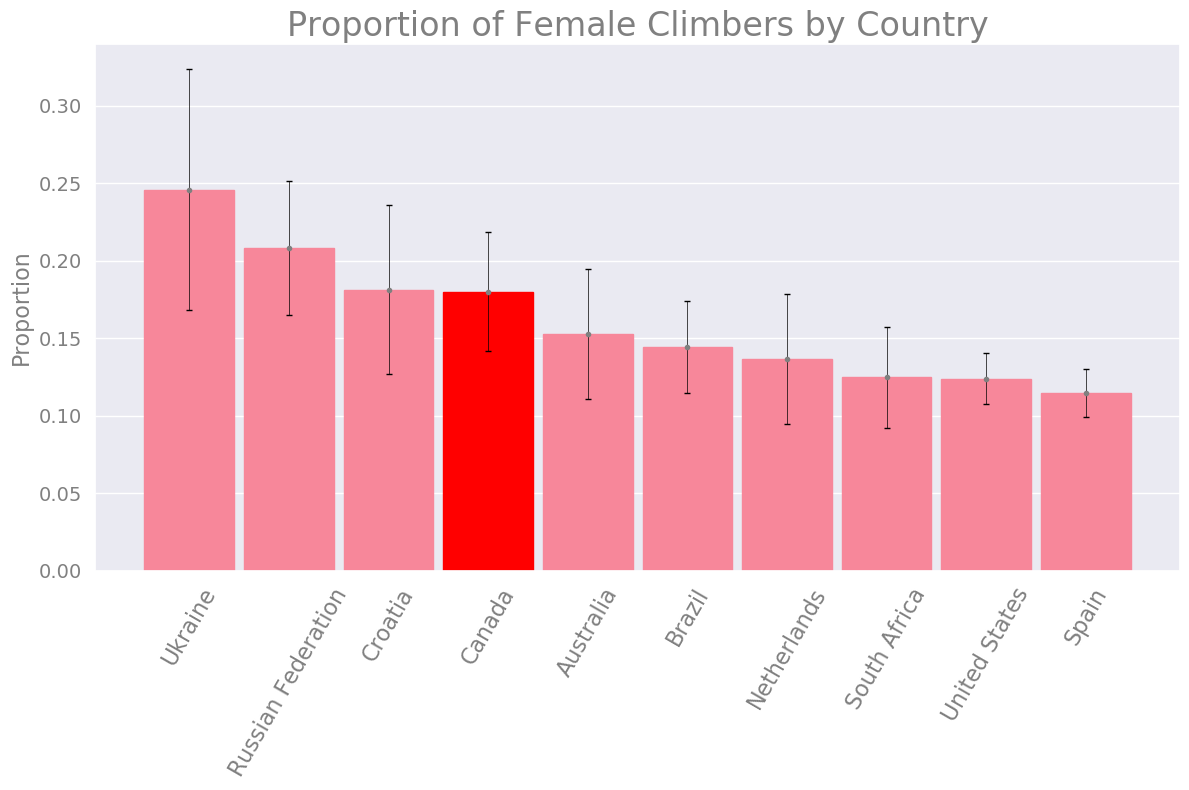

In [9]:
sex_country = (climbers_sex
               .groupby(['country_climber_name', 'sex'])[['sex']]
               .count()
               .rename(columns = {'sex':'sex_count'})
              )

totals = sex_country.reset_index().groupby('country_climber_name').sex_count.sum()
sex_country = sex_country.reset_index().set_index('country_climber_name')
sex_country['sex_total'] = totals
sex_country = df_add_prop_error(sex_country, 'sex')

N = 10
f = (sex_country.sex=='Female') & (sex_country.sex_count > 25)
sex_country_results = (sex_country[f]
                       .sort_values(by='sex_prop', ascending=False)
                       .head(N)
                       .reset_index())

# set up the colors for the plot
colors = [mrd_palette[1]]*N
colors[int(sex_country_results[sex_country_results.country_climber_name=='Canada'].index.values)] = (1,0,0)

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(12,8))
    ax.bar(sex_country_results.country_climber_name,
           sex_country_results.sex_prop,
           color = colors,
           edgecolor = colors,
           width=0.9)


    ax.errorbar(x=list(range(10)), 
                y = sex_country_results.sex_prop,
                yerr = sex_country_results.sex_prop_err,
                fmt='.', color='grey',
                ecolor='black', 
                elinewidth=0.5, 
                capsize=2)

    ax.set_title('Proportion of Female Climbers by Country',
                 fontsize = TITLE_SIZE,
                 color = 'grey')
    ax.set_ylabel('Proportion',
                  fontsize=LABEL_SIZE,
                  color = 'grey')
    ax.set_xlabel("")
    ax.set_xticks(sex_country_results.country_climber_name)
    ax.set_xticklabels(sex_country_results.country_climber_name, 
                       rotation=60, 
                       fontsize = TICK_SIZE, 
                       color = 'grey', 
                       ha='center')
    ax.tick_params(axis='y',
                   labelcolor = 'grey',
                   labelsize=14)
    ax.xaxis.grid(linewidth=0)

plt.tight_layout()
plt.savefig(OUTPUT_PATH + "female_country.png")
plt.show()

### Climbers Per Country Per Capital

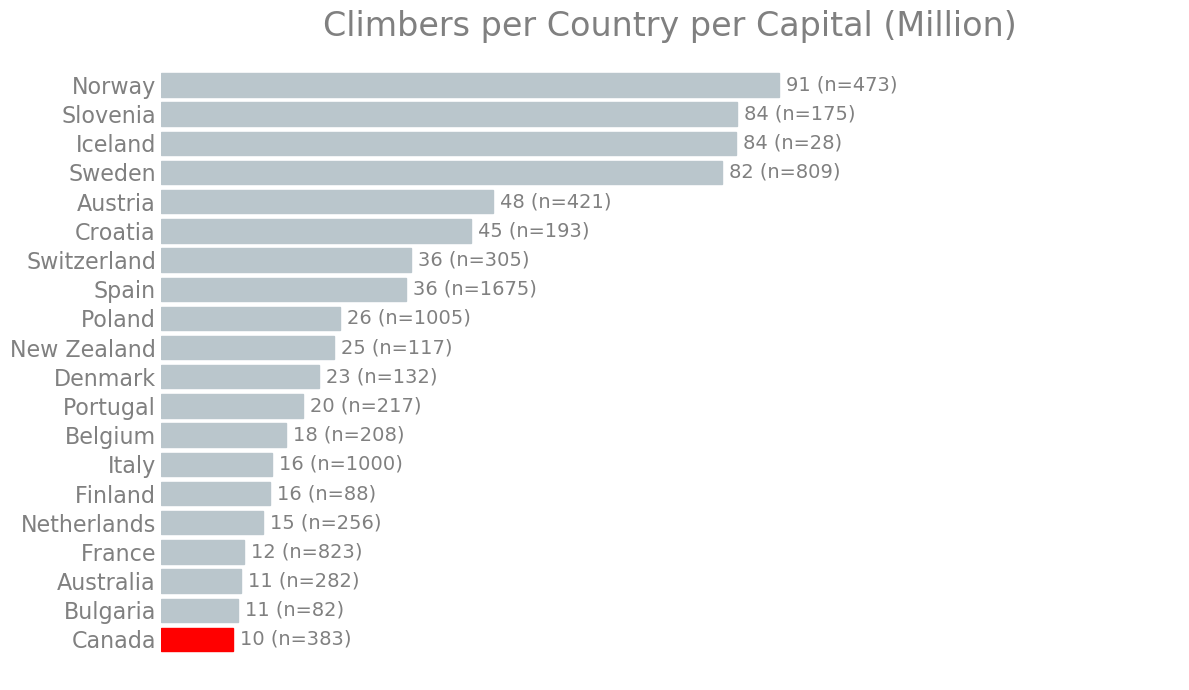

In [10]:
# get the climbers per country
climber_country = (climbers_sex
                   .groupby('country_climber_name')
                   .count()
                   .sort_values(by='user_id', ascending = False)
                   .reset_index())
climber_country_counts = (
    pd.merge(left = climber_country[['country_climber_name', 'user_id']],
             left_on = 'country_climber_name',
             right = pop2015.drop(columns = 'Indicator Code'),
             right_on = 'Country Name',
             how = 'left')
)
# filter for countries with at least 25 climbers
climber_country_counts = climber_country_counts[climber_country_counts.user_id > 25].dropna()
# convert to per million
climber_country_counts = (
    climber_country_counts
    .assign(climber_per_M = climber_country_counts['user_id'] * ( 1e6 / climber_country_counts['2015'] ))
    .reset_index(drop=True)
)

# get only the top 20 countries
# had to display 20 to get Canada to show up
N = 20
country_small = (climber_country_counts
                 .sort_values(by='climber_per_M', ascending=False)
                 .head(N)
                 .sort_values(by='climber_per_M')
                 .reset_index(drop=True))
idx_canada = int(country_small[country_small.country_climber_name == 'Canada'].index.values)

colors = [mrd_palette[2]]*N  # grey
colors[idx_canada] = (1,0,0) # index for canada

with plt.style.context('default'):
    fig, ax = plt.subplots(figsize=(12,7))

    bars = ax.barh(country_small.country_climber_name,
                   country_small.climber_per_M,
                   color = colors,
                   edgecolor = colors)
    
    ax.set_title('Climbers per Country per Capital (Million)', fontsize = TITLE_SIZE,  color = 'grey')
    ax.set_xlabel("")
    ax.set_ylabel("")

    ax.yaxis.grid(linewidth=0)
    ax.set_yticklabels(country_small['Country Name'], fontsize = TICK_SIZE, color = 'grey')
    ax.set_xlim(0,150)
    ax.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False,
        length = 0) # labels along the bottom edge are 

    for i, rect in enumerate(bars):
        width = rect.get_width()
        label = str(int(country_small.loc[i,"climber_per_M"])) + " (n=" + str(country_small.loc[i,"user_id"]) + ")"
        ax.text(width + 1, 
                rect.get_y() + rect.get_height() / 2.,
                label, #str(int(width)),
                ha='left', va='center', fontsize = TICK_SIZE-2, color='grey')
        
    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)
        
    fig.tight_layout()
    plt.savefig(OUTPUT_PATH + "climbers_country.png")
    plt.show()

## Start looking at Grades - Height and BMI

Build a climbing dataframe to be used for analysis.

In [11]:
climbs_grouped = (
    climbs_all
    .groupby(['user_id', 'sex'])
    .agg({'grade_id':'max',
          'bmi':'first',
          'height':'first'})
    .reset_index()
)
climbs_grouped = (
    pd.merge(left = climbs_grouped, 
             left_on = 'grade_id',
             right = grades, right_on = 'id',
             how = 'left')
    .drop(columns=['id', 'score', 'fra_boulders', 'usa_boulders'])
)
climbs_grouped['usa_routes'] = climbs_grouped.usa_routes.astype(usa_routes_type)
climbs_grouped['grades_reduced'] = climbs_grouped.usa_routes.astype('object')

# filter for routes > 5.9
f = climbs_grouped.usa_routes > '5.9'
climbs_grouped.loc[f, 'grades_reduced'] = climbs_grouped.loc[f, 'grades_reduced'].apply(lambda x:str(x)[:-1])

# create my own codes for later analysis
prime_grades = ['5.9', '5.10', '5.11', '5.12', '5.13', '5.14', '5.15']
sub_grades = ['a', 'b', 'c', 'd']
grade_dict = {}
count = 1
for p in prime_grades:
    if p == '5.9':
        grade_dict[p] = count
        count += 1
    else:
        for s in sub_grades:
            grade_dict[p + s] = count
            count += 1
# now reverse the dictionary
grade_dict_inv = {v: k for k, v in grade_dict.items()}

climbs_grouped['grade_codes'] = climbs_grouped[f].usa_routes.replace(grade_dict)

### Histogram of Routes

Create a histogram dataframe to be used for the next few plots.

In [12]:
grade_his = (
    climbs_grouped
    .groupby('usa_routes')
    .bmi
    .agg(['mean', 'std', 'count'])
    .rename(columns={'mean':'bmi_mean', 
                     'std':'bmi_std', 
                     'count':'grade_cnt'})
    .reset_index()
)

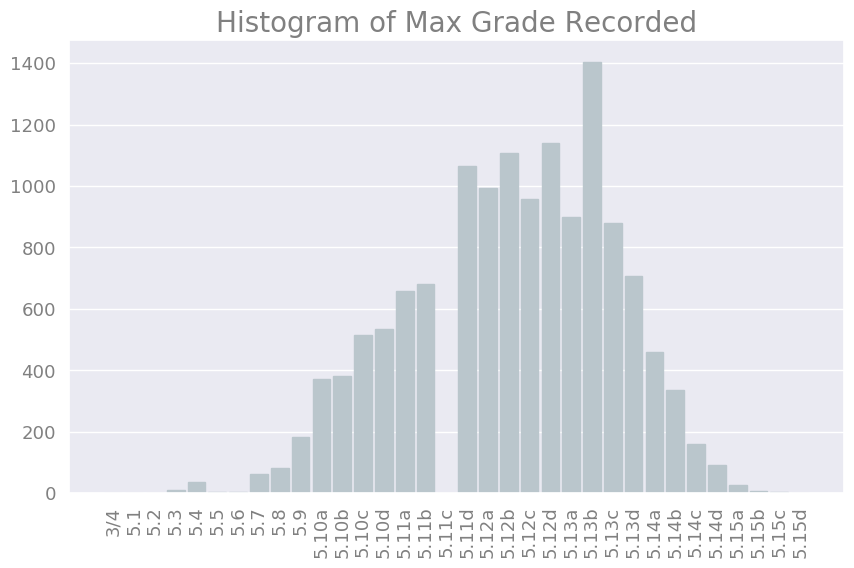

In [13]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=FIG_SIZE)
    ax.bar(grade_his.usa_routes,
           grade_his.grade_cnt,
           color = mrd_palette[2],
           edgecolor = mrd_palette[2],
           width=0.85)

    ax.set_title('Histogram of Max Grade Recorded', fontsize = 20, color = 'grey')
    ax.set_xlabel("")
    ax.set_ylabel("")

    ax.xaxis.grid(linewidth=0)
    ax.tick_params(axis='both', labelcolor = 'grey', labelsize=13)
    ax.set_xticklabels(grade_his.usa_routes, rotation=90)

plt.savefig(OUTPUT_PATH + "histogram_grade.png")
plt.show()

### Density of Routes

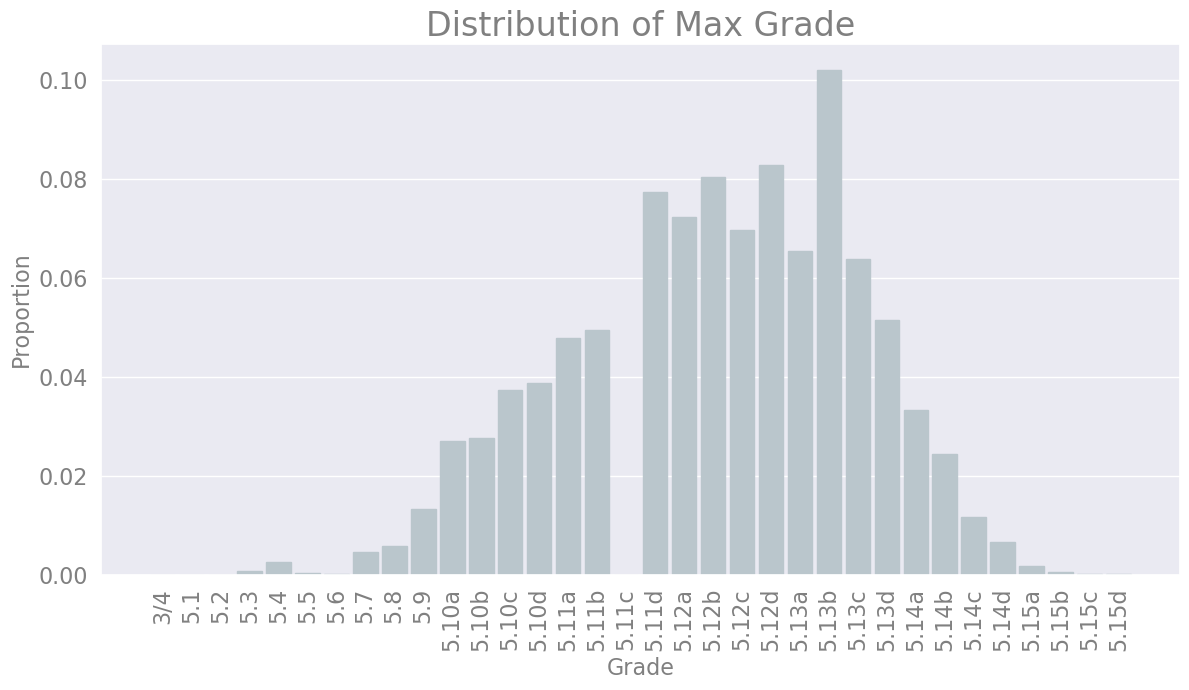

In [14]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(12,7))
    ax.bar(grade_his.usa_routes,
           grade_his.grade_cnt / grade_his.grade_cnt.sum(),
           color = mrd_palette[2],
           edgecolor = mrd_palette[2],
           width=0.85)

    ax.xaxis.grid(linewidth=0)
    ax.tick_params(axis='both', labelcolor = 'grey', labelsize=TICK_SIZE)
    ax.set_xticklabels(grade_his.usa_routes, rotation=90)

    ax.set_title('Distribution of Max Grade', fontsize = TITLE_SIZE, color = 'grey')
    ax.set_ylabel("Proportion", fontsize = LABEL_SIZE, color = 'grey')
    ax.set_xlabel("Grade", fontsize = LABEL_SIZE, color = 'grey')

plt.tight_layout()
plt.savefig(OUTPUT_PATH + "density_grade.png")
plt.show()

### Cumulative Distribution of Grade

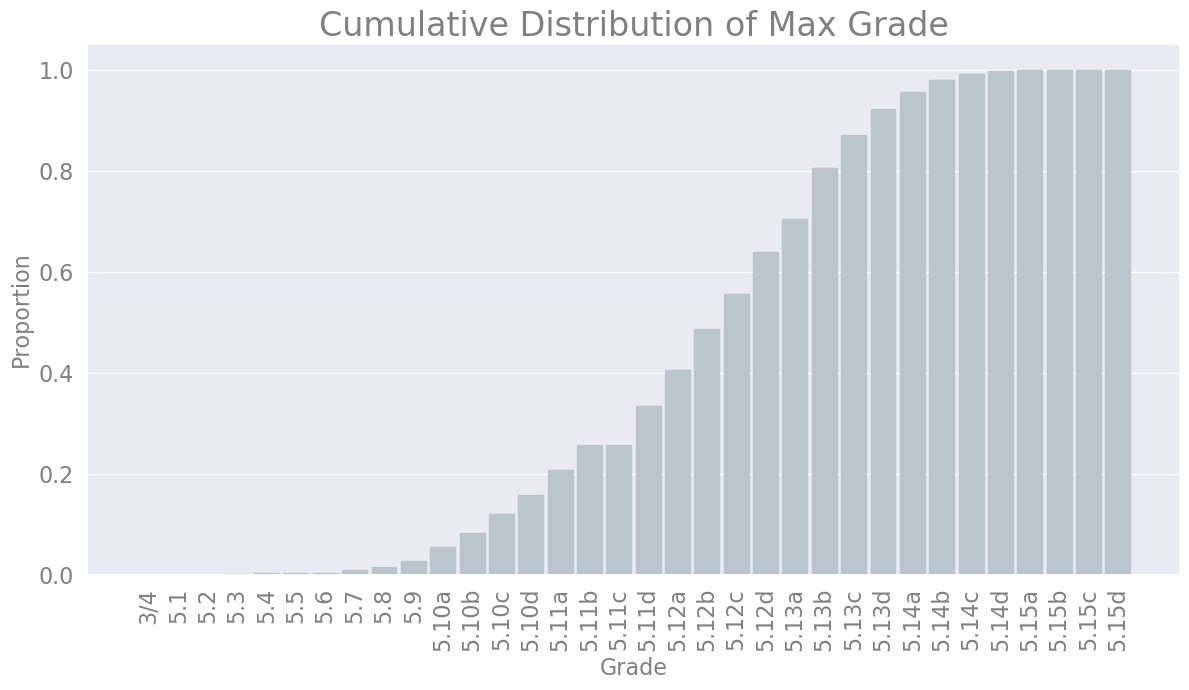

In [15]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(12,7))
    ax.bar(grade_his.usa_routes,
           np.cumsum(grade_his.grade_cnt / grade_his.grade_cnt.sum()),
           color = mrd_palette[2],
           edgecolor = mrd_palette[2],
           width=0.85)

    ax.set_title('Cumulative Distribution of Max Grade', fontsize = TITLE_SIZE, color = 'grey')
    ax.set_ylabel("Proportion", fontsize = LABEL_SIZE, color = 'grey')
    ax.set_xlabel("Grade", fontsize = LABEL_SIZE, color = 'grey')

    ax.xaxis.grid(linewidth=0)
    ax.tick_params(axis='both', labelcolor = 'grey', labelsize=TICK_SIZE)
    ax.set_xticklabels(grade_his.usa_routes, rotation=90)

plt.tight_layout()
plt.savefig(OUTPUT_PATH + "cumulative_distribution_grade.png")
plt.show()

In [16]:
climbs_grouped

,user_id,sex,grade_id,bmi,height,fra_routes,usa_routes,grades_reduced,grade_codes
0,1,Male,62,23.301095,177,8a,5.13b,5.13,15.0
1,3,Male,62,24.074074,180,8a,5.13b,5.13,15.0
2,4,Female,64,21.303949,165,8a+,5.13c,5.13,16.0
3,10,Male,64,22.589551,167,8a+,5.13c,5.13,16.0
4,16,Male,64,21.705129,177,8a+,5.13c,5.13,16.0
...,...,...,...,...,...,...,...,...,...
13755,66988,Male,33,23.291230,183,5c,5.9,5.9,NaN
13756,67009,Male,59,23.140496,165,7c+,5.13a,5.13,14.0
13757,67015,Female,49,19.024970,145,7a,5.11d,5.11,9.0
13758,67019,Male,46,24.675500,172,6c+,5.11b,5.11,7.0


Create a dataframe to use for a simplified version of the above histograms.

In [17]:
f = climbs_grouped.grades_reduced.isin(['5.9', '5.10', '5.11', '5.12', '5.13', '5.14'])
grade_his_red = (
    climbs_grouped[f]
    .groupby('usa_routes')[['bmi','height']]
    .agg(['mean', 'std', 'count'])
    .dropna()
    .reset_index()
)
grade_his_red.columns = grade_his_red.columns.droplevel()
new_cols = (
    ['grade'] + 
    [unit + '_' + agg for unit in ['bmi', 'height'] 
                      for agg in ['mean', 'std', 'count']]
)
grade_his_red.columns = new_cols

f = grade_his_red.grade > '5.9'
grade_his_red['grades_reduced'] = grade_his_red['grade'].astype(str)
grade_his_red.loc[f, 'grades_reduced'] = grade_his_red.loc[f, 'grades_reduced'].apply(lambda x:str(x)[:-1])

# add errors to be used later
grade_his_red['bmi_err'] = 1.96 * grade_his_red['bmi_std'] / np.sqrt(grade_his_red['bmi_count'])
grade_his_red['height_err'] = 1.96 * grade_his_red['height_std'] / np.sqrt(grade_his_red['height_count'])

### Histogram of Routes (reduced)

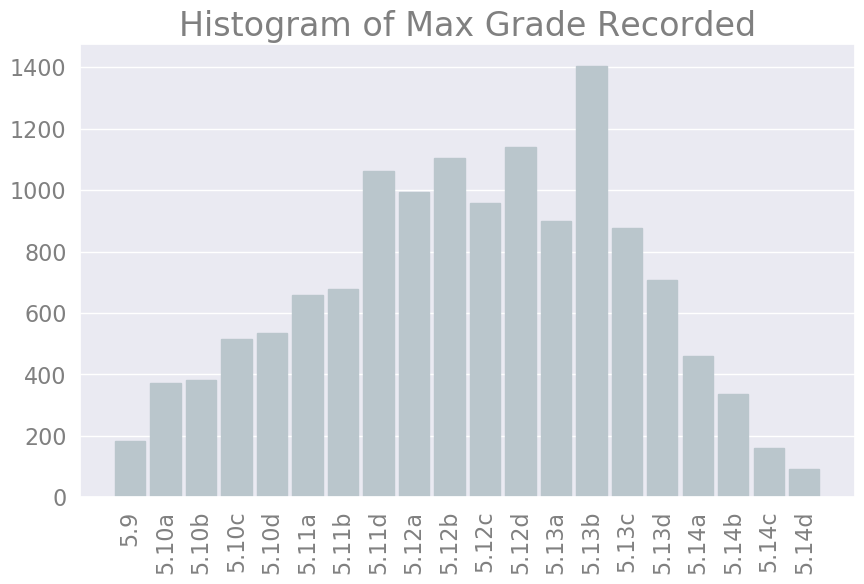

In [18]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=FIG_SIZE)
    ax.bar(grade_his_red.grade,
           grade_his_red.bmi_count,
           color = mrd_palette[2],
           edgecolor = mrd_palette[2],
           width=0.85)

    ax.xaxis.grid(linewidth=0)
    ax.tick_params(axis='both', labelcolor = 'grey', labelsize=TICK_SIZE)
    ax.set_xticklabels(grade_his_red.grade, rotation=90)

    ax.set_title('Histogram of Max Grade Recorded', fontsize = TITLE_SIZE, color = 'grey')
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.show()

### Density of Routes (reduced)

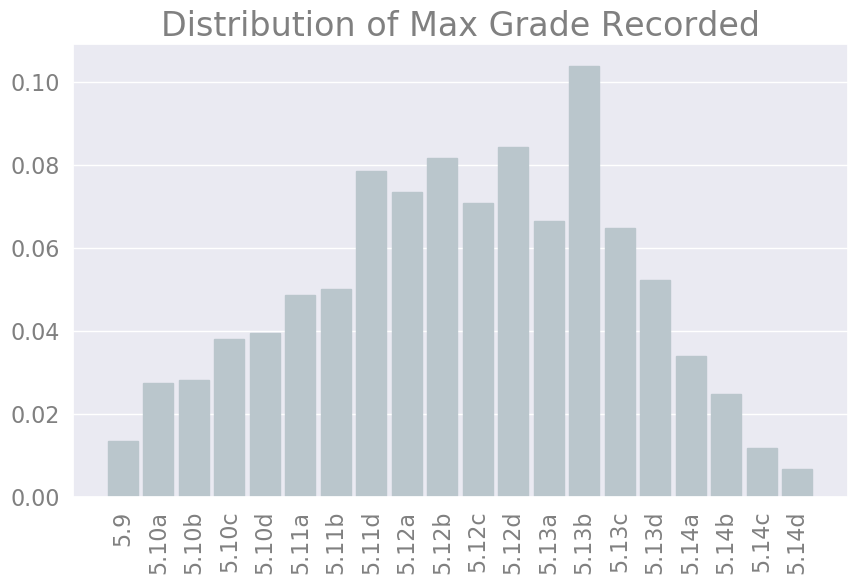

In [19]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=FIG_SIZE)
    ax.bar(grade_his_red.grade,
           grade_his_red.bmi_count / grade_his_red.bmi_count.sum(),
           color = mrd_palette[2],
           edgecolor = mrd_palette[2],
           width=0.85)

    ax.xaxis.grid(linewidth=0)
    ax.tick_params(axis='both', labelcolor = 'grey', labelsize=TICK_SIZE)
    ax.set_xticklabels(grade_his_red.grade, rotation=90)

    ax.set_title('Distribution of Max Grade Recorded', fontsize = TITLE_SIZE, color = 'grey')
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.show()

### Grades by Sex

Create two new data frames to get a version of climbs in a subset of grades as well as a version of climbs with statistics for `BMI` and `Height` by gender.

In [20]:
# grades
grades_to_keep = ['5.9', '5.10', '5.11', '5.12', '5.13', '5.14']

# dataframe of reduced climbs with grades converted to strings
f = climbs_grouped.grades_reduced.isin(grades_to_keep)
climbs_study = climbs_grouped[f].copy()
climbs_study['grades'] = climbs_grouped[f].usa_routes.astype(str)
climbs_study['height_jit'] = (
    climbs_study.height + np.random.uniform(-0.5, 0.5, len(climbs_study))
)

# build a new climbing dataframe with additional grouping by sex
grades_by_sex = (
    climbs_grouped[f]
    .groupby(['usa_routes', 'sex', 'grades_reduced'])[['bmi','height']]
    .agg(['mean', 'std', 'count'])
    .dropna()
)
grades_by_sex.columns = grades_by_sex.columns.droplevel()
grades_by_sex = grades_by_sex.reset_index()
new_cols = (
    ['grade', 'sex', 'grades_reduced'] + 
    [unit + '_' + agg for unit in ['bmi', 'height'] 
                      for agg in ['mean', 'std', 'count']]
)
grades_by_sex.columns = new_cols

# add errors
grades_by_sex['bmi_err'] = 1.96 * grades_by_sex['bmi_std'] / np.sqrt(grades_by_sex['bmi_count'])
grades_by_sex['height_err'] = 1.96 * grades_by_sex['height_std'] / np.sqrt(grades_by_sex['bmi_count'])

### BMI vs Max Grade

Create some reusable plotting functions to reduce the code later

In [21]:
# create some colors
color_top = mrd_palette[0]
color_f = mrd_palette[1]
color_bottom = mrd_palette[2]

def plot_err_sex(x, y, yerr, ax, sex):
    if sex == 'Male':
        color = color_top
    else:
        color = color_f
        
    ax.errorbar(x,
                y,
                yerr, 
                fmt='.-', ms=10,
                mec = color,
                mfc = color,
                elinewidth = 2,
                ecolor = color,
                color = color,
                capsize=2,
                zorder = 2,
                alpha = 1
                )


def plot_grades_by_error(df, ax, sex, height = True):
    y_col = 'height_mean' if height else 'bmi_mean'
    y_err_col = 'height_err' if height else 'bmi_err'
    f = df.sex == sex
    x = df[f].grade
    y = df[f].loc[:, y_col]
    yerr = df[f].loc[:, y_err_col]
    
    plot_err_sex(x, y, yerr, ax, sex)
             

def plot_stripplot(ax, sex, height = True):
    if sex == 'Male':
        #color = sns.color_palette('pastel')[0]
        color = [c / 255. for c in (198, 220, 245)]
    else:
        #color = sns.color_palette('pastel')[6]
        color = [c / 255. for c in (240,190,215)]
    ax = sns.stripplot(data=climbs_study[climbs_study.sex == sex],
                       x="grades", 
                       y='height_jit' if height else 'bmi', 
                       size = 4, 
                       jitter = True, 
                       color = color, 
                       alpha = .4, 
                       zorder = 1
                       )

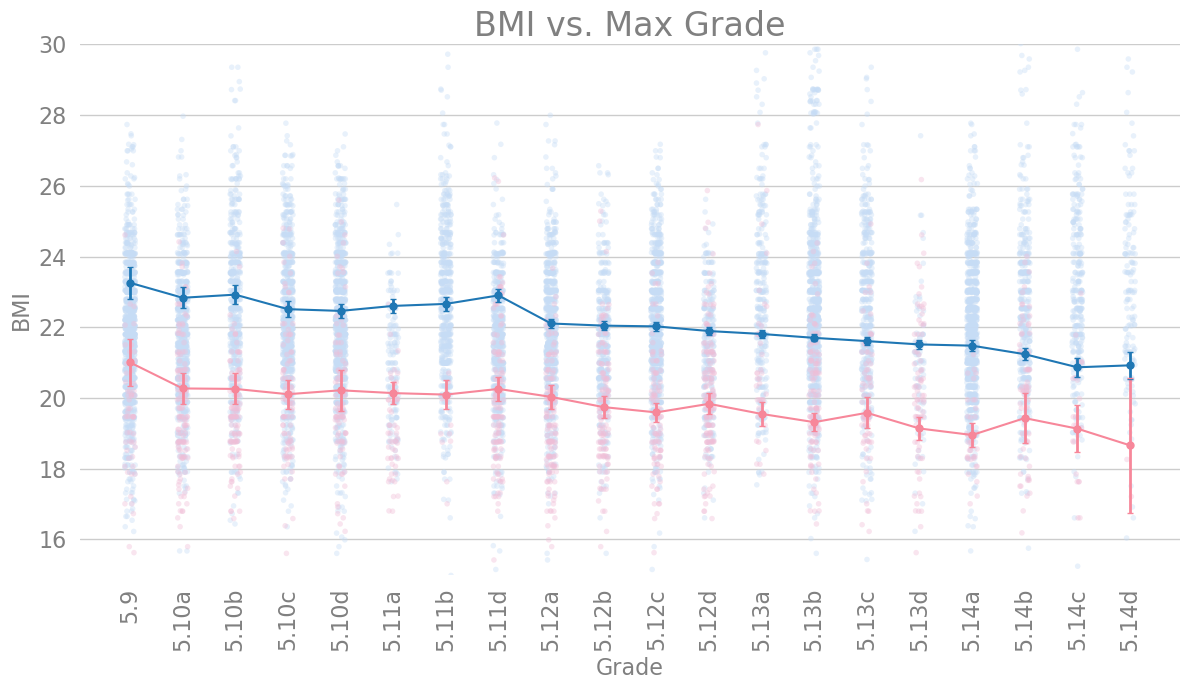

In [22]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(12,7))

    plot_stripplot(ax, "Male", height = False)
    plot_stripplot(ax, "Female", height = False)
    plot_grades_by_error(grades_by_sex, ax, "Male", height = False)
    plot_grades_by_error(grades_by_sex, ax, "Female", height = False)
                 
    ax.set_ylim(15,30)
    ax.xaxis.grid(linewidth=0)
    ax.tick_params(axis='both', labelcolor = 'grey', labelsize=TICK_SIZE)
    ax.set_xticklabels(grade_his_red.grade, rotation=90)
    ax.set_title('BMI vs. Max Grade', fontsize = TITLE_SIZE, color = 'grey')
    ax.set_xlabel("Grade", color = 'grey', fontsize = LABEL_SIZE)
    ax.set_ylabel("BMI", color = 'grey', fontsize = LABEL_SIZE)
    for loc in ['right', 'top', 'left', 'bottom']:
        ax.spines[loc].set_visible(False)

plt.tight_layout()
plt.savefig(OUTPUT_PATH + 'bmi_vs_grade.png')
plt.show()

### Height vs Max Grade

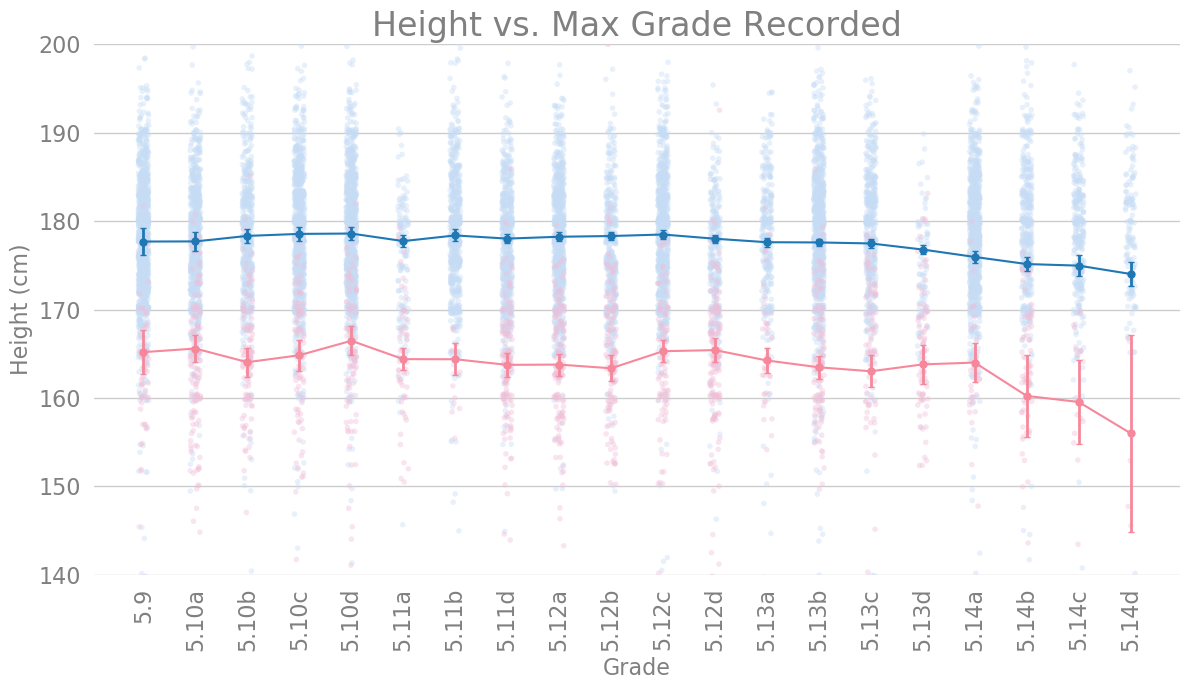

In [23]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(12,7))

    plot_stripplot(ax, "Male", height = True)
    plot_stripplot(ax, "Female", height = True)
    plot_grades_by_error(grades_by_sex, ax, "Male", height = True)
    plot_grades_by_error(grades_by_sex, ax, "Female", height = True)

    ax.set_ylim(140,200)
    ax.xaxis.grid(linewidth=0)
    ax.tick_params(axis='both', labelcolor = 'grey', labelsize=TICK_SIZE)
    ax.set_xticklabels(grade_his_red.grade, rotation=90)
    plt.title('Height vs. Max Grade Recorded', fontsize = TITLE_SIZE, color = 'grey')
    plt.xlabel("Grade", color = 'grey', fontsize = LABEL_SIZE)
    plt.ylabel("Height (cm)", color = 'grey', fontsize = LABEL_SIZE)
    for loc in ['right', 'top', 'left', 'bottom']:
        ax.spines[loc].set_visible(False)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH + 'height_vs_grade.png')
    plt.show()

### New Dataframes to Create Max Grade vs BMI and Max Grade vs Height

Now, I really like the above two plots, but after staring at them for a while they didn't really provide me with the insight I was hoping to get. I came up with the idea to basically flip the x-y axis', but that isn't so simple as i don't want the x-axis to be continuous.

I first need to bin the `Height` and `BMI` and create some groups from that.

In [24]:
climbs_grp_bins = climbs_grouped.copy()

bmi_bins = [0] + list(range(17, 27)) + [28, 100]
climbs_grp_bins['bmi_bins'] = pd.cut(climbs_grouped.bmi, bmi_bins)

f = climbs_grp_bins.sex == 'Male'
male_height_bins = [0] + list(range(165, 195, 5)) + [1000]
climbs_grp_bins.loc[f, 'height_bins_male'] = pd.cut(climbs_grp_bins[f].height, 
                                                    male_height_bins)

f = climbs_grp_bins.sex == 'Female'
female_height_bins = [0] + list(range(150, 180, 5)) + [1000]
climbs_grp_bins.loc[f, 'height_bins_female'] = pd.cut(climbs_grp_bins[f].height, 
                                                      female_height_bins)

climbs_grp_bins['height_bins'] = (
    climbs_grp_bins.height_bins_male.fillna('').astype('str') +
    climbs_grp_bins.height_bins_female.fillna('').astype('str')
)
#climbs_grp_bins['height_bins_str'] = climbs_grp_bins['height_bins']

def build_height_bmi_df(df, h_or_bmi):
    if h_or_bmi == 'height':
        bins = 'height_bins'
        agg_col = 'bmi'
    else:
        bins = 'bmi_bins'
        agg_col = 'height'

    f = df.grades_reduced.isin(grades_to_keep)
    agg_funs = ['mean', 'std', 'count']
    cols = [agg_col, 'grade_codes']
    result = (
        df[f]
        .groupby([bins, 'sex'])[cols]
        .agg(agg_funs)
    )
    result.columns = result.columns.droplevel()
    result = result.reset_index()
    col_names = (
        [bins, 'sex'] + [c + '_' + agg for c in cols for agg in agg_funs]
    )
    result.columns = col_names
    # calculate errros
    for c in cols:
        result[c+'_err'] = 1.96*result[c+'_std'] / np.sqrt(result[c+'_count'])
    
    return result

# it was necessary to perform some shenanigans to get the height plot to 
# display correctly with split axis'
height_bin_codes = {
    "(0, 150]":  0,
    "(150, 155]":  1,
    "(155, 160]":  2,
    "(160, 165]":  3,
    "(165, 170]":  4,
    "(170, 175]":  5,
    "(175, 180]":  6,
    "(180, 185]":  7,
    "(185, 190]":  8,
    "(0, 165]":  3,
    "(175, 1000]":  6,
    "(190, 1000]":  9,
}

grades_by_bmi = build_height_bmi_df(climbs_grp_bins, 'bmi')
grades_by_height = build_height_bmi_df(climbs_grp_bins, 'height')
grades_by_height['height_bins_codes'] = grades_by_height['height_bins'].replace(height_bin_codes)

#### Distributions of Bins

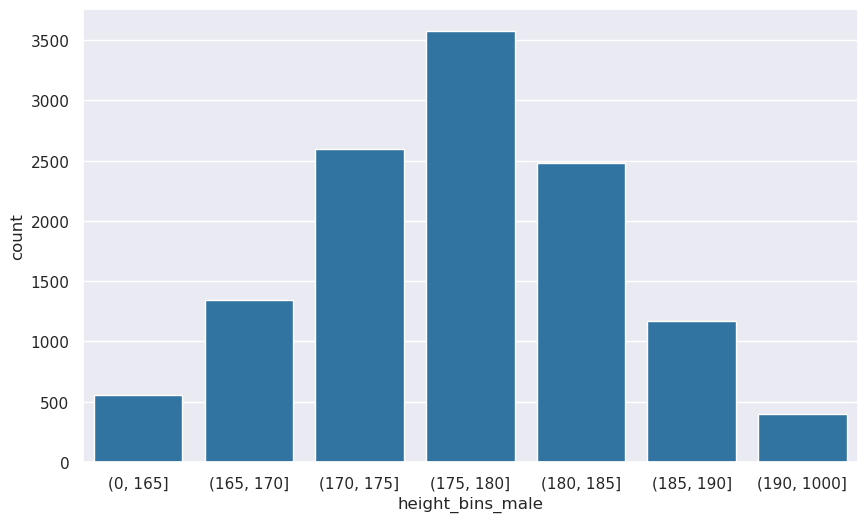

In [25]:
plt.figure(figsize = FIG_SIZE)
f = climbs_grp_bins.sex == "Male"
sns.countplot(climbs_grp_bins[f].height_bins_male.sort_values(),
              color = mrd_palette[0])
plt.show()

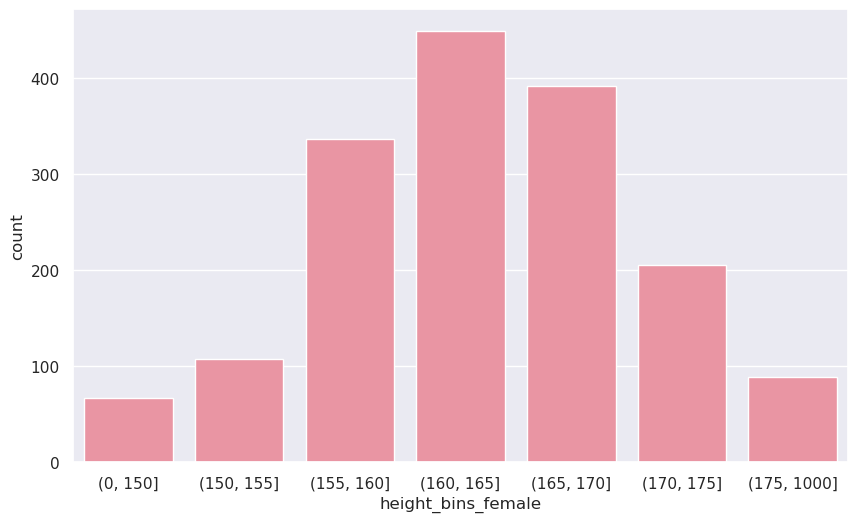

In [26]:
plt.figure(figsize = FIG_SIZE)
f = climbs_grp_bins.sex == "Female"
sns.countplot(climbs_grp_bins[f].height_bins_female.sort_values(),
              color = mrd_palette[1])
plt.show()

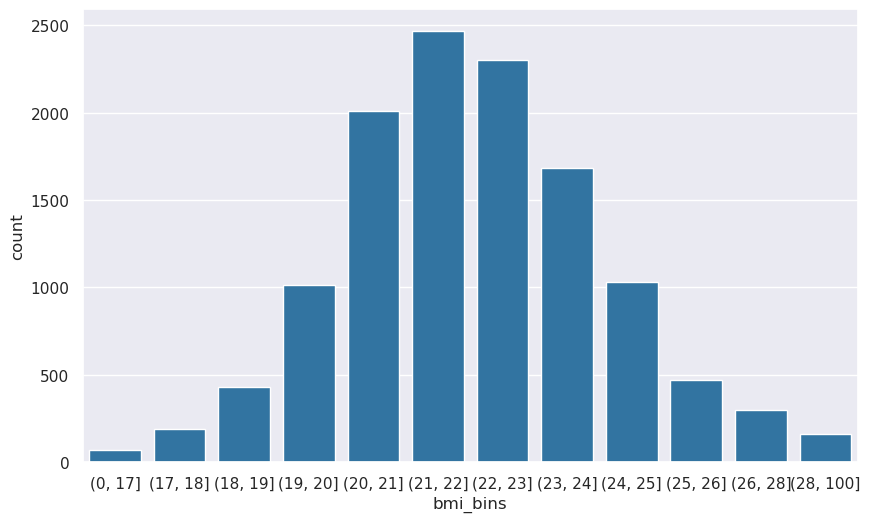

In [27]:
plt.figure(figsize = FIG_SIZE)
f = climbs_grp_bins.sex == "Male"
sns.countplot(climbs_grp_bins[f].bmi_bins.sort_values(),
              color = mrd_palette[0])
plt.show()

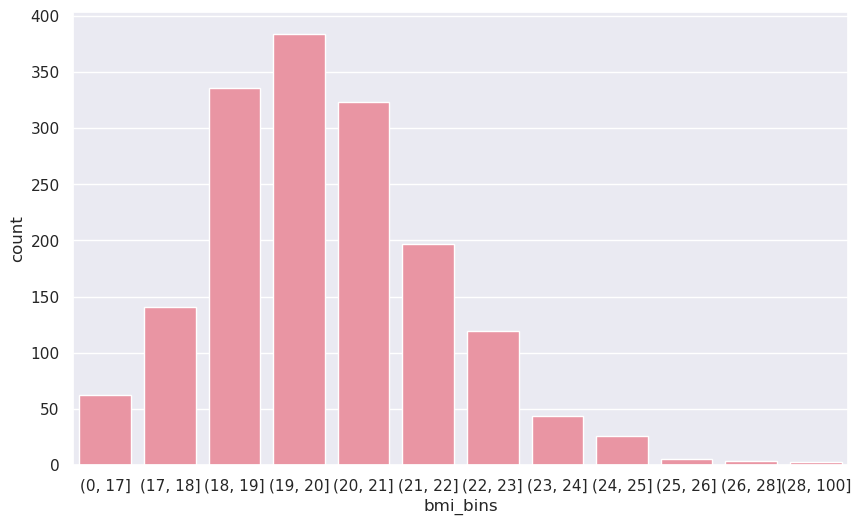

In [28]:
plt.figure(figsize = FIG_SIZE)
f = climbs_grp_bins.sex == "Female"
sns.countplot(climbs_grp_bins[f].bmi_bins.sort_values(),
              color = mrd_palette[1])
plt.show()

### Max Grade vs BMI

In [29]:
def plot_grades_by_bmi_or_height(df, sex, h_or_b, ax):
    if h_or_b == 'height':
        bins = 'height_bins_codes'
    else:
        bins = 'bmi_bins'

    f = df.sex == sex
    
    x = df[f].loc[:, bins].astype('str')
    y = df[f].grade_codes_mean
    yerr = df[f].grade_codes_err
    
    plot_err_sex(x, y, yerr, ax, sex)

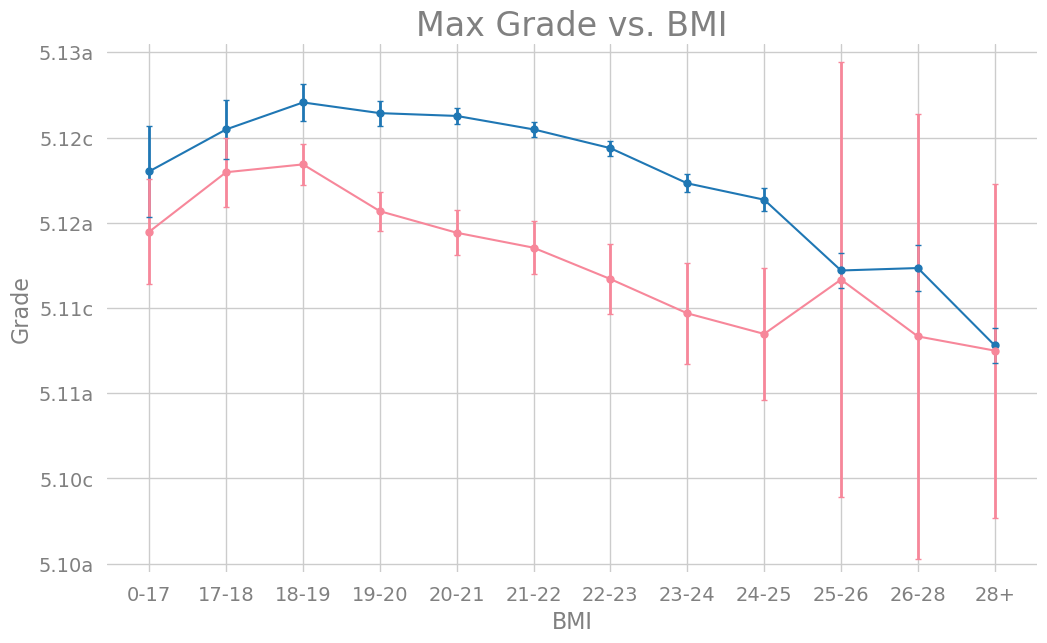

In [30]:
color_top = mrd_palette[0]
color_f = mrd_palette[1]
color_bottom = mrd_palette[2]

with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(12,7))
    plot_grades_by_bmi_or_height(grades_by_bmi, "Male", 'bmi', ax)
    plot_grades_by_bmi_or_height(grades_by_bmi, "Female", 'bmi', ax)
        
    # make nice x-labels
    bmi_bins = grades_by_bmi.bmi_bins.unique().astype('str')
    xlabels = [re.sub('\(|\]', '', s).replace(', ', '-') for s in bmi_bins]
    xlabels[-1] = '28+'
    ax.set_xticklabels(xlabels, rotation=0)
    ax.set_ylim(1.8,14.2)
    ax.set_yticklabels([grade_dict_inv[int(tick)] if tick > 0 else "xxx" for tick in ax.get_yticks()] )
    ax.tick_params(axis='both', labelcolor = 'grey', labelsize=14)
        
    ax.xaxis.grid(linewidth=1, linestyle = '-')
    ax.yaxis.grid(linewidth=1, linestyle = '-')
    
    ax.set_title('Max Grade vs. BMI', fontsize = TITLE_SIZE, color = 'grey')
    ax.set_xlabel("BMI", color = 'grey', fontsize = LABEL_SIZE)
    ax.set_ylabel("Grade", color = 'grey', fontsize = LABEL_SIZE)
    for loc in ['right', 'top', 'left', 'bottom']:
        ax.spines[loc].set_visible(False)

    plt.savefig(OUTPUT_PATH + 'grade_vs_bmi.png')
    plt.show()

### Max Grade vs Height

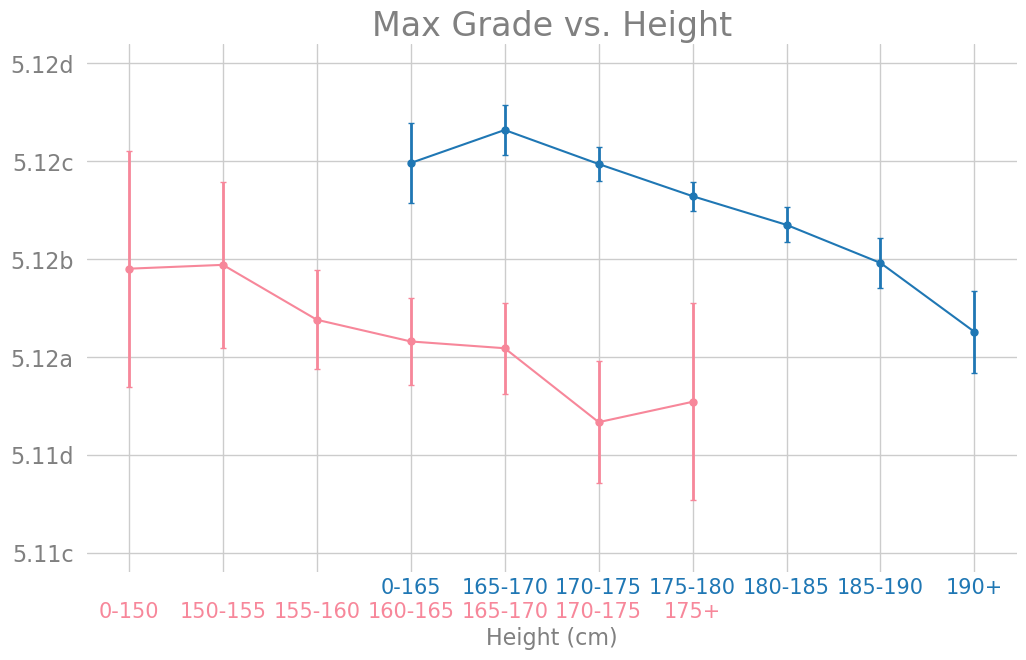

In [32]:
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import AutoMinorLocator

color_top = mrd_palette[0]
color_f = mrd_palette[1]
color_bottom = mrd_palette[2]


with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(12,7))
    
    
    plot_grades_by_bmi_or_height(grades_by_height, "Female", 'height', ax)
    plot_grades_by_bmi_or_height(grades_by_height, "Male", 'height', ax)
    
    ax.set_ylim(7.8,13.2)
    ax.xaxis.grid(True, which='minor',linewidth=1)
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.tick_params(axis='y', labelcolor = 'grey', labelsize=TICK_SIZE)
    ax.tick_params(axis='x', 
                   labelcolor = color_top,
                   labelsize=TICK_SIZE-1,
                   length=0,
                   bottom=False, 
                   top=False, 
                   left=False, 
                   right=False)
    
    male_x_labels = ['', '', '', '', '0-165', '165-170', '170-175', '175-180', '180-185', '185-190', '190+']
    female_x_labels = ['', '0-150', '150-155', '155-160', '160-165', '165-170', '170-175', '175+', '', '', '']
    
    ax.set_xticklabels(male_x_labels, rotation=0)
    ax.set_yticklabels([grade_dict_inv[int(tick)] if tick > 0 else "xxx" for tick in ax.get_yticks()] )
    
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    
    # Move twinned axis ticks and label from top to bottom
    ax2.xaxis.set_ticks_position("bottom")
    ax2.xaxis.set_label_position("bottom")
    ax2.spines["bottom"].set_position(("axes", -0.03))
    ax2.patch.set_visible(False)
    ax2.xaxis.grid(linewidth=0)
    ax2.yaxis.grid(linewidth=0)
    ax2.xaxis.set_major_locator(MultipleLocator(1))
    
    ax2.tick_params(which='both', 
                    axis='both', 
                    labelcolor = color_f, 
                    labelsize=TICK_SIZE-1, 
                    bottom=False, 
                    top=False, 
                    left=False, 
                    right=False)
    ax2.set_xticklabels(female_x_labels, rotation=0)
    
    for loc in ['right', 'top', 'left', 'bottom']:
        ax.spines[loc].set_visible(False)
        ax2.spines[loc].set_visible(False)
    
    plt.title('Max Grade vs. Height', fontsize = TITLE_SIZE, color = 'grey')
    plt.xlabel("Height (cm)", color = 'grey', fontsize = LABEL_SIZE)
    plt.ylabel("Grade", color = 'grey', fontsize = LABEL_SIZE)
    plt.savefig(OUTPUT_PATH + 'grade_vs_height.png')
    plt.show()